In [1]:
import copy
import os
import random
import time
import timeit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

from torch import optim
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, models, transforms

from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    roc_curve,
)

In [2]:
# Setting manual seed for reproducibility
manual_seed = 999
print(f"Random Seed: {manual_seed}")
torch.manual_seed(manual_seed)

Random Seed: 999


In [3]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

print(os.listdir("../data/chest_xray - Copy/chest_xray/"))

['.DS_Store', 'test', 'train', 'val']


In [4]:
datadir = "../data/chest_xray - Copy/chest_xray/"

traindir = f"{datadir}train/"
testdir = f"{datadir}test/"
validdir = f"{datadir}val/"

save_file_name = "vgg19-chest-augmented.pt"
checkpoint_path = "vgg19-chest-augmented.pth"

In [5]:
BATCH_SIZE = 64
NUM_GPU = torch.cuda.device_count() if torch.cuda.is_available() else 0

device = torch.device("cuda:0" if NUM_GPU else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [6]:
categories: list[str] = []
img_categories: list[str] = []
n_train: list[int] = []
n_valid: list[int] = []
n_test: list[int] = []
hs: list[int] = []
ws: list[int] = []

In [7]:
for item in os.listdir(traindir):
    if item.startswith('.'):
        continue

    categories.append(item)

    train_imgs = os.listdir(traindir + item)
    valid_imgs = os.listdir(validdir + item)
    test_imgs = os.listdir(testdir + item)

    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    for img in train_imgs:
        if img.startswith('.'):
            continue

        img_categories.append(item)
        image = Image.open(traindir + item + '/' + img)
        # img_array = np.array(img)

        hs.append(image.height)
        ws.append(image.width)

In [8]:
cat_df = pd.DataFrame({
    "category": categories,
    "n_train": n_train,
    "n_valid": n_valid,
    "n_test": n_test
})

cat_df.head()

,category,n_train,n_valid,n_test
0,NORMAL,1470,9,234
1,PNEUMONIA,4004,9,390


<AxesSubplot: xlabel='category'>

(array([0, 1]), [Text(0, 0, 'NORMAL'), Text(1, 0, 'PNEUMONIA')])

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training images by category')

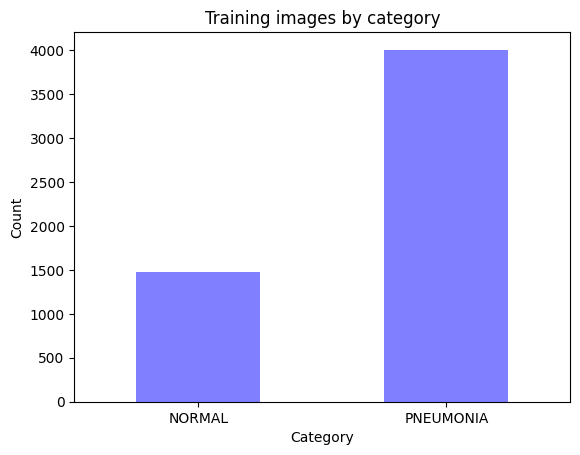

In [9]:
cat_df.set_index("category")['n_train'].plot.bar(color='b', alpha=0.5)

plt.xticks(rotation=0)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Training images by category")
plt.show()

In [10]:
image_df = pd.DataFrame({
    "category": img_categories,
    "height": hs,
    "width": ws
})

image_df.head()

,category,height,width
0,NORMAL,128,128
1,NORMAL,128,128
2,NORMAL,128,128
3,NORMAL,128,128
4,NORMAL,128,128


In [11]:
img_dsc = image_df.groupby('category').mean()

min_width = image_df.sort_values(by=['width'])
# min_height = image_df.sort_values(by=['height'])

min_width.head()
# min_height.head()

print(img_dsc)

,category,height,width
0,NORMAL,128,128
1573,PNEUMONIA,128,128
1572,PNEUMONIA,128,128
1571,PNEUMONIA,128,128
1570,PNEUMONIA,128,128


                height        width
category                           
NORMAL     1272.214432  1533.571137
PNEUMONIA   802.738696  1166.189858


<Figure size 1000x600 with 0 Axes>

<AxesSubplot: xlabel='height', ylabel='Density'>

<AxesSubplot: xlabel='height', ylabel='Density'>

Text(0.5, 0, 'Pixels')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Average Size Distribution')

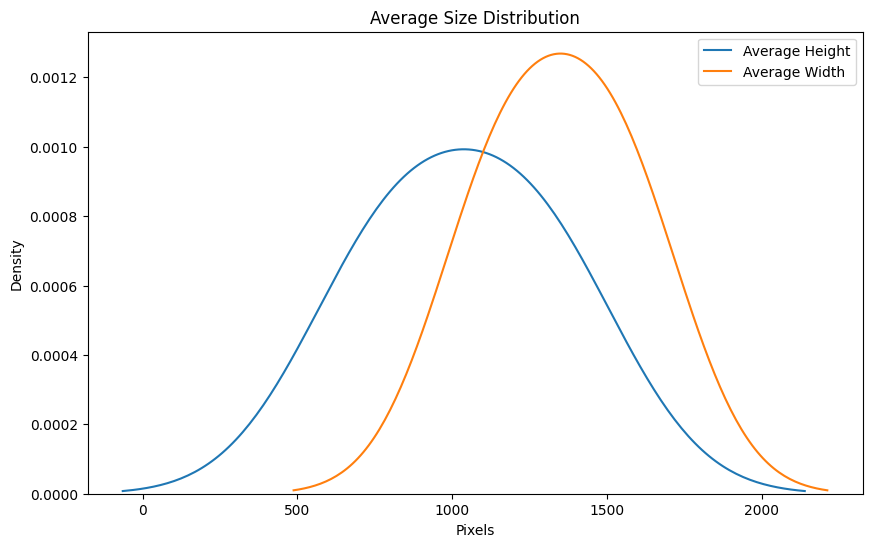

In [12]:
plt.figure(figsize=(10, 6))

sns.kdeplot(img_dsc['height'], label='Average Height')
sns.kdeplot(img_dsc['width'], label='Average Width')

plt.xlabel("Pixels")
plt.ylabel("Density")
plt.legend()
plt.title("Average Size Distribution")
plt.show()

In [13]:
def show(image, title: str=""):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

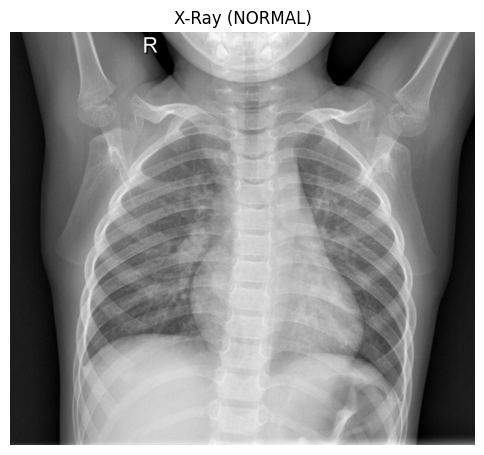

Image Size: 2090 x 1858


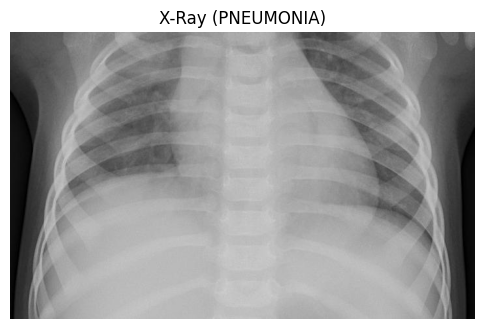

Image Size: 712 x 439


In [14]:
x = Image.open(f"{traindir}NORMAL/IM-0115-0001.jpeg")
show(x, title="X-Ray (NORMAL)")
print(f"Image Size: {x.width} x {x.height}")

y = Image.open(f"{traindir}PNEUMONIA/person1_bacteria_1.jpeg")
show(y, title="X-Ray (PNEUMONIA)")
print(f"Image Size: {y.width} x {y.height}")

In [15]:
# Data Transformations and Normalization for Training and Validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [16]:
image_datasets = {x: datasets.ImageFolder(
    os.path.join(datadir, x), 
    data_transforms[x]) for x in ['train', 'val', 'test'] if not x.startswith('.')}
dataloaders = {x: DataLoader(
    image_datasets[x], 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True) for x in ['train', 'val', 'test'] if not x.startswith('.')}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test'] if not x.startswith('.')}
class_names = image_datasets['train'].classes

print(f"Training images: {dataset_sizes['train']}")
print(f"Validation images: {dataset_sizes['val']}")
print(f"Testing images: {dataset_sizes['test']}")

print(f"Classes: {class_names}")

Training images: 5472
Validation images: 16
Testing images: 624
Classes: ['NORMAL', 'PNEUMONIA']


In [17]:
def imshow(inp: torch.Tensor , title: str | None = None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

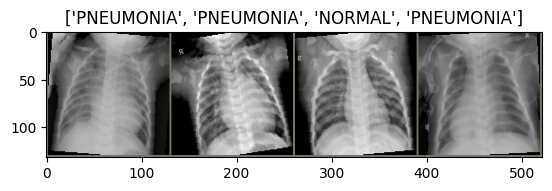

In [18]:
# Get a batch of training data and select the first 4 images
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch and select the first 4 images
out = torchvision.utils.make_grid(inputs[:4])
# out = torchvision.utils.make_grid(inputs)

imshow(out, title=[f"{class_names[x]}" for x in classes[:4]])

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label'
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(
        ax.get_xticklabels(), 
        rotation=45, 
        ha="right", 
        rotation_mode="anchor"
    )

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], fmt), 
                ha="center", va="center", 
                color="white" if cm[i, j] > thresh else "black"
            )
    fig.tight_layout()
    plt.show()
    
    return ax

In [20]:
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    avg_precision = average_precision_score(y_true, y_score)
    
    plt.step(recall, precision, color='b', alpha=0.25, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f"Two-class Precision-Recall curve: AP={avg_precision:0.2f}")
    plt.show()


In [21]:
def plot_classification_report(y_true, y_pred, figsize=(10,10)):
    cr = classification_report(y_true, y_pred, output_dict=True)
    print(classification_report(y_true, y_pred))
    
    categories = list(cr.keys())
    categories = [x for x in categories if x not in ['micro avg', 'macro avg', 'weighted avg',]]
    categories.sort()

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([0, 1], [0, 1])
    ax.set_yticks(range(len(categories)))
    ax.set_yticklabels(categories)
    ax.xaxis.tick_top()
    ax.set_xlabel('Score')
    ax.set_ylabel('Metric')
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    for i, category in enumerate(categories):
        if category == 'accuracy':
            continue
        
        precision = cr.get(category, {}).get('precision', 0)
        recall = cr.get(category, {}).get('recall', 0)
        f1 = cr.get(category, {}).get('f1-score', 0)
        ax.barh(i, precision, color='b', alpha=0.5)
        ax.barh(i, recall, color='g', alpha=0.5)
        ax.barh(i, f1, color='r', alpha=0.5)


    plt.tight_layout()
    plt.legend()
    plt.show()


In [22]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(
        fpr, tpr,  lw=lw, 
        color='r', alpha=0.5,
        label='ROC curve (area = %0.2f)' % roc_auc
    )
    plt.plot([0, 1], [0, 1], color='b', alpha=0.5, lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [23]:
def plot_loss_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.plot(history['train_loss'], label='train loss', color='b', alpha=0.5)
    ax1.plot(history['val_loss'], label='val loss', color='r', alpha=0.5)
    ax1.set_title('Loss')
    ax1.legend()
    ax2.plot(history['train_acc'], label='train acc', color='b', alpha=0.5)
    ax2.plot(history['val_acc'], label='val acc', color='r', alpha=0.5)
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs: int=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    all_y_true = []
    all_y_pred = []

    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch}/{num_epochs - 1}]')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_y_true += labels.tolist()
                all_y_pred += preds.tolist()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]).cpu().numpy()

            if phase == 'train':
                training_losses.append(epoch_loss)
                training_accuracies.append(epoch_acc)
            else:
                validation_losses.append(epoch_loss)
                validation_accuracies.append(epoch_acc)

            # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:4f}')
    print()

    history = {
        'train_loss': training_losses,
        'val_loss': validation_losses,
        'train_acc': training_accuracies,
        'val_acc': validation_accuracies
    }

    print('Loss and Accuracy:')
    plot_loss_accuracy(history)
    print()

    print('Classification Report:')
    plot_classification_report(all_y_true, all_y_pred)
    print()

    print('Confusion Matrix:')
    plot_confusion_matrix(all_y_true, all_y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

    print('ROC Curve:')
    plot_roc_curve(all_y_true, all_y_pred)
    print()

    print('Precision-Recall Curve:')
    plot_precision_recall_curve(all_y_true, all_y_pred)
    print()

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [25]:
def visualize_model(model, num_images: int=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(5, 5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(
                    f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}', 
                    fontdict={'size': 10}
                )
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [26]:
model_ft = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model_ft = nn.DataParallel(model_ft)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Using 2 GPUs!


Epoch [0/24]
----------


c:\Users\Administrator\Documents\1707057\Thesis\venv\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch [1/24]
----------
Epoch [2/24]
----------
Epoch [3/24]
----------
Epoch [4/24]
----------
Epoch [5/24]
----------
Epoch [6/24]
----------
Epoch [7/24]
----------
Epoch [8/24]
----------
Epoch [9/24]
----------
Epoch [10/24]
----------
Epoch [11/24]
----------
Epoch [12/24]
----------
Epoch [13/24]
----------
Epoch [14/24]
----------
Epoch [15/24]
----------
Epoch [16/24]
----------
Epoch [17/24]
----------
Epoch [18/24]
----------
Epoch [19/24]
----------
Epoch [20/24]
----------
Epoch [21/24]
----------
Epoch [22/24]
----------
Epoch [23/24]
----------
Epoch [24/24]
----------

Training complete in 25m 45s
Best Val Acc: 1.000000

Loss and Accuracy:


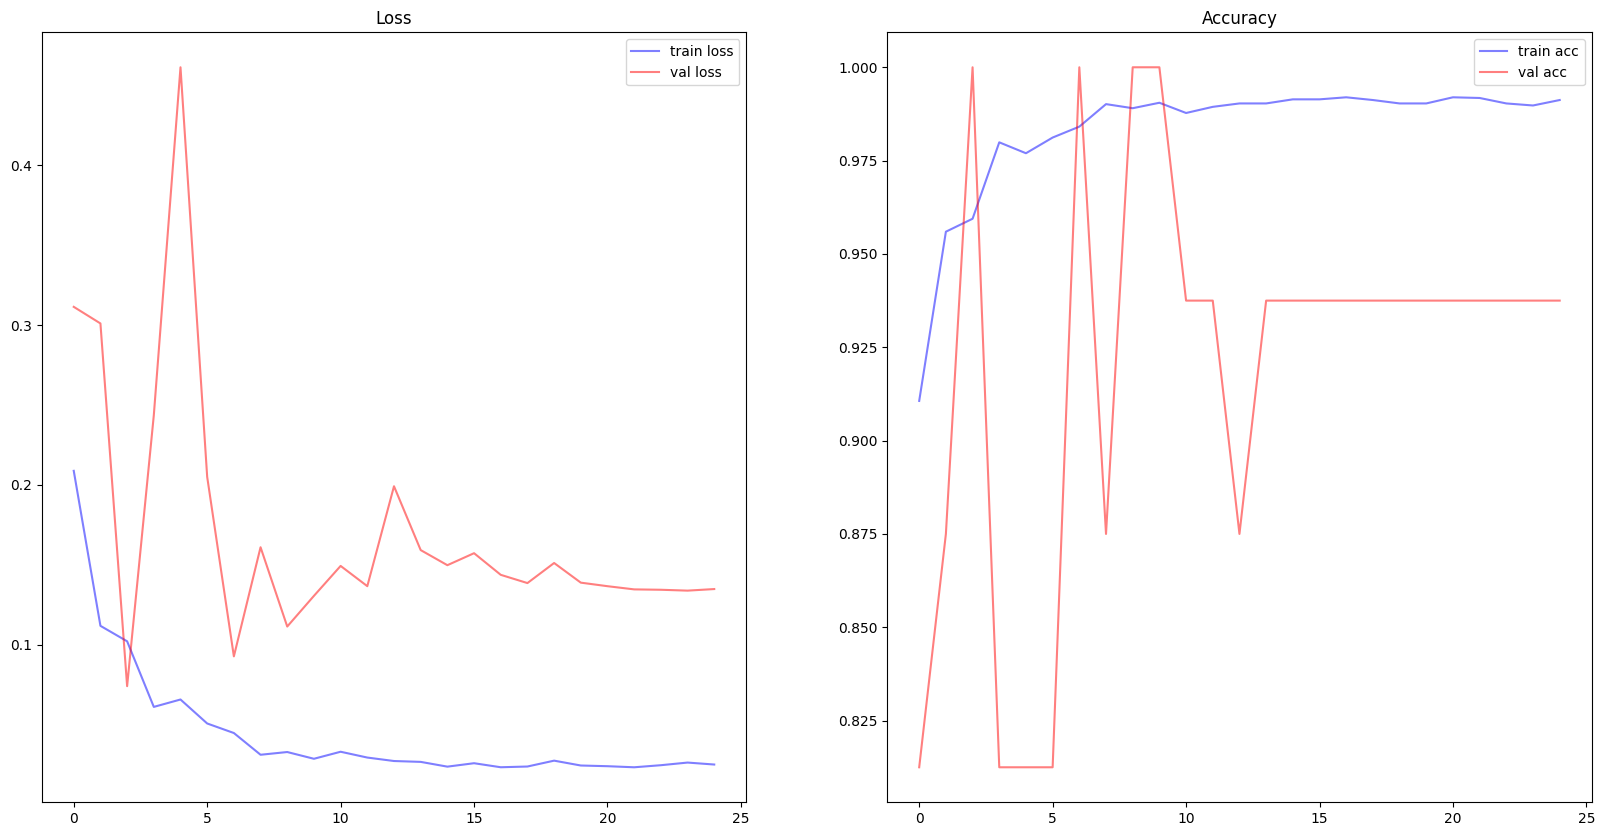


Classification Report:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

           0       0.97      0.97      0.97     36925
           1       0.99      0.99      0.99    100275

    accuracy                           0.98    137200
   macro avg       0.98      0.98      0.98    137200
weighted avg       0.98      0.98      0.98    137200



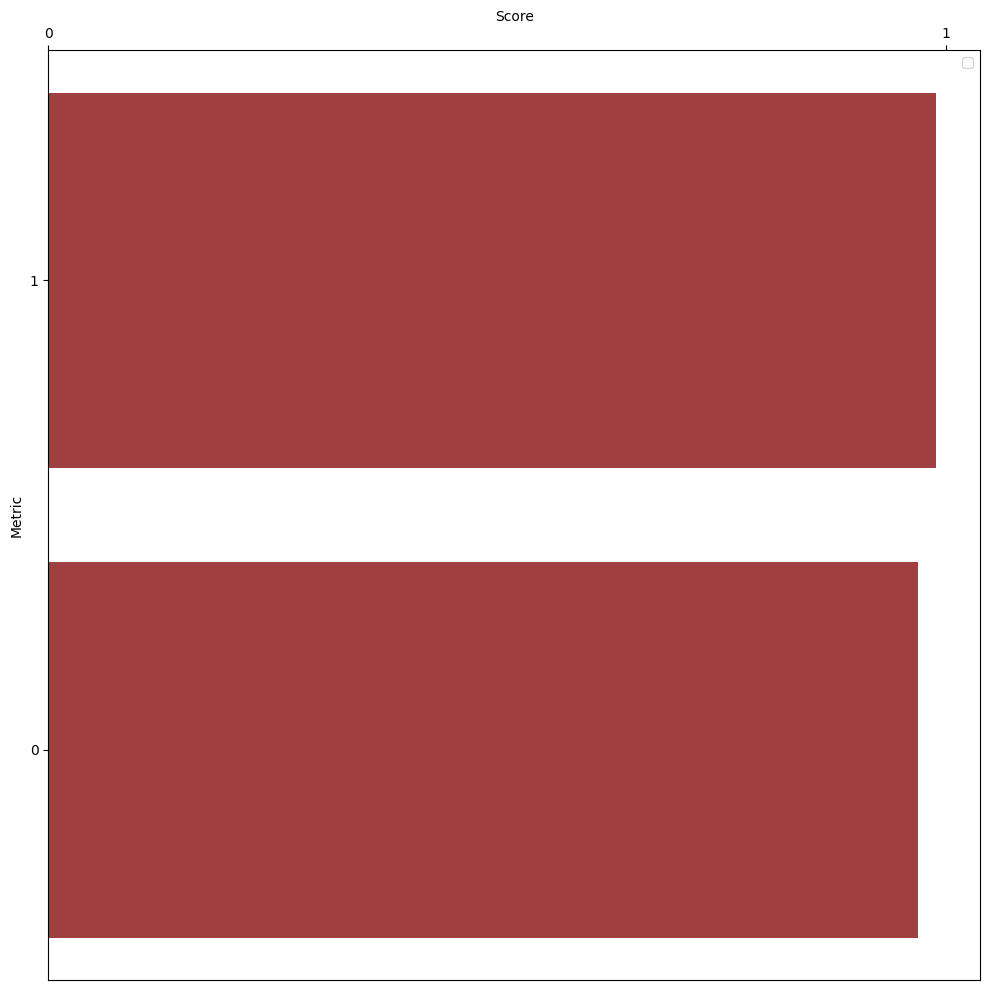


Confusion Matrix:
Normalized confusion matrix
[[0.96820582 0.03179418]
 [0.01167789 0.98832211]]


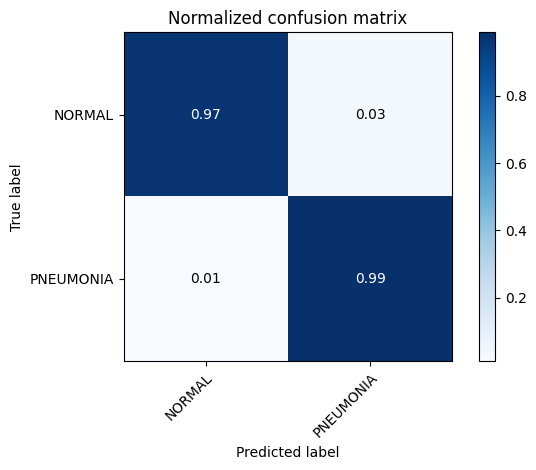

ROC Curve:


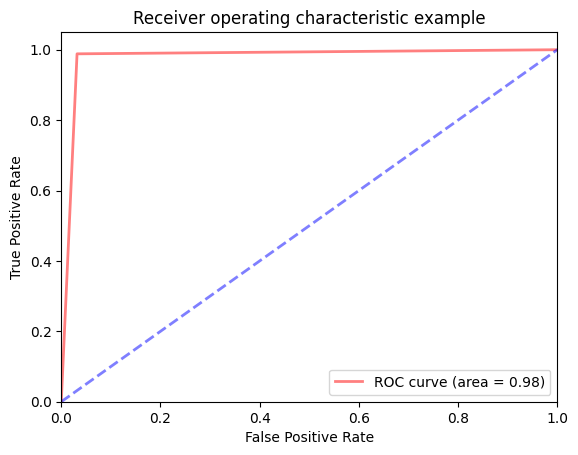


Precision-Recall Curve:


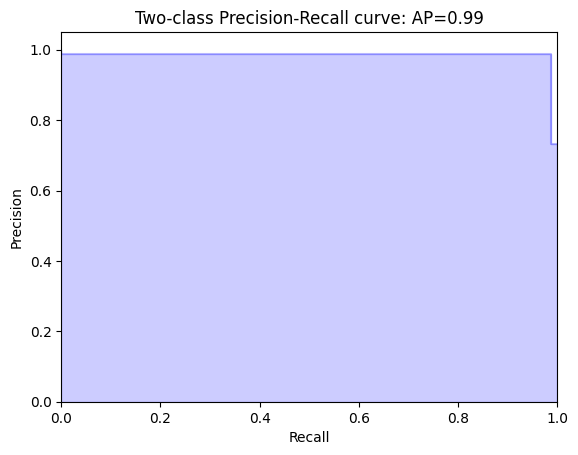

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

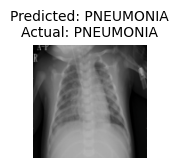

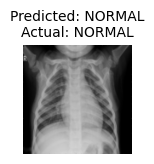

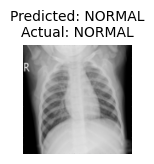

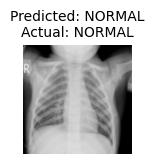

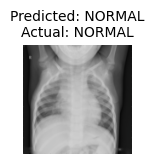

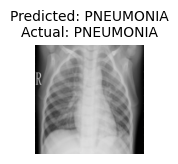

In [28]:
visualize_model(model_ft)

plt.ioff()
plt.show()

# ConvNet as fixed feature extractor

In [29]:
model_conv = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 2)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model_conv = nn.DataParallel(model_conv)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Using 2 GPUs!


Epoch [0/24]
----------


c:\Users\Administrator\Documents\1707057\Thesis\venv\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch [1/24]
----------
Epoch [2/24]
----------
Epoch [3/24]
----------
Epoch [4/24]
----------
Epoch [5/24]
----------
Epoch [6/24]
----------
Epoch [7/24]
----------
Epoch [8/24]
----------
Epoch [9/24]
----------
Epoch [10/24]
----------
Epoch [11/24]
----------
Epoch [12/24]
----------
Epoch [13/24]
----------
Epoch [14/24]
----------
Epoch [15/24]
----------
Epoch [16/24]
----------
Epoch [17/24]
----------
Epoch [18/24]
----------
Epoch [19/24]
----------
Epoch [20/24]
----------
Epoch [21/24]
----------
Epoch [22/24]
----------
Epoch [23/24]
----------
Epoch [24/24]
----------

Training complete in 22m 37s
Best Val Acc: 0.937500

Loss and Accuracy:


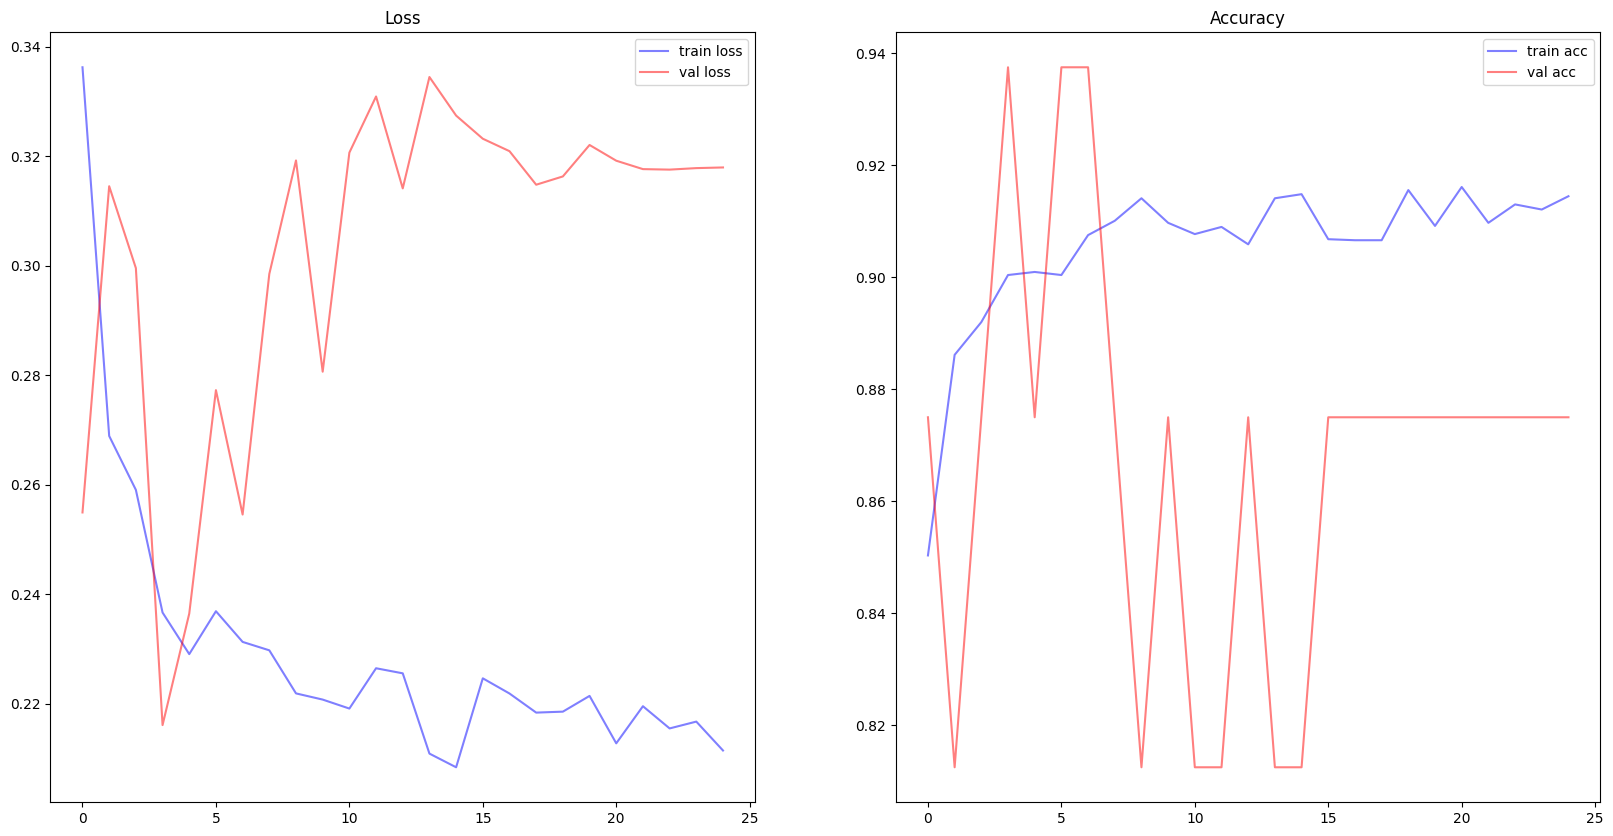


Classification Report:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

           0       0.84      0.80      0.82     36925
           1       0.93      0.95      0.94    100275

    accuracy                           0.91    137200
   macro avg       0.88      0.87      0.88    137200
weighted avg       0.90      0.91      0.90    137200



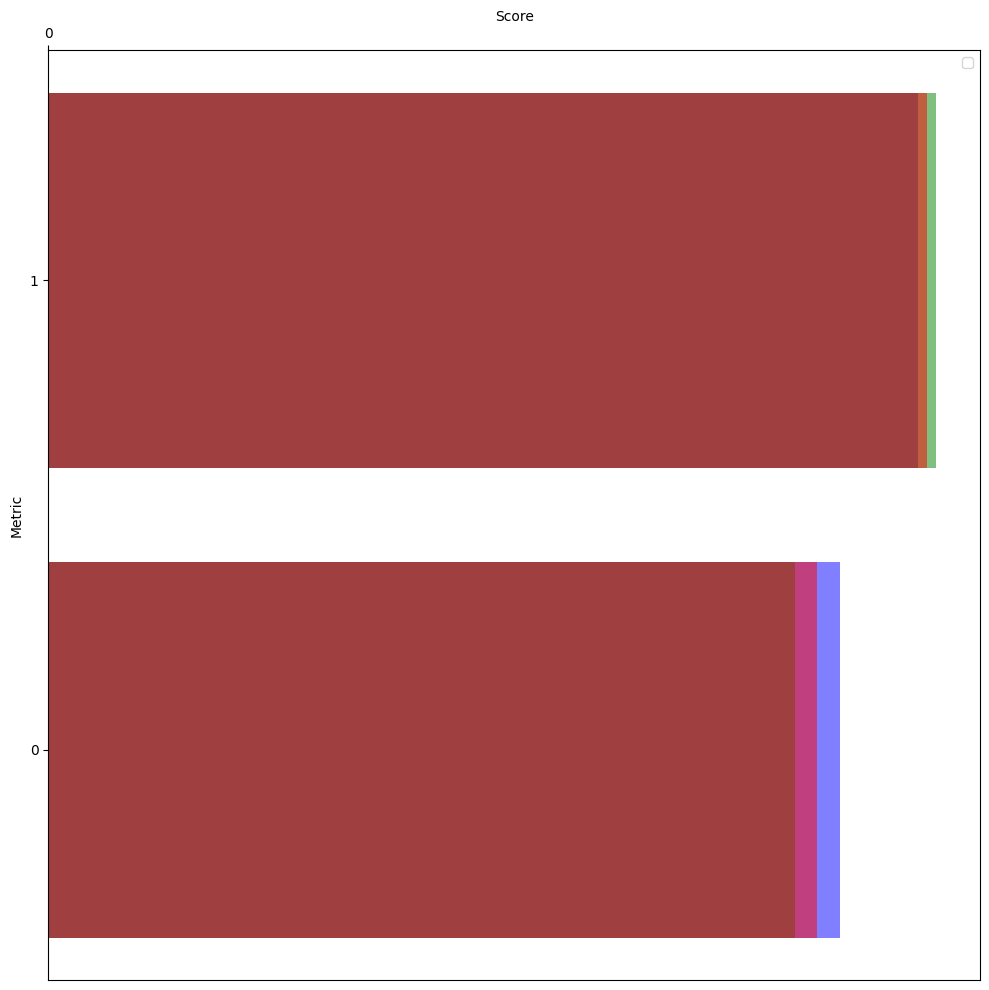


Confusion Matrix:
Normalized confusion matrix
[[0.79593771 0.20406229]
 [0.05453004 0.94546996]]


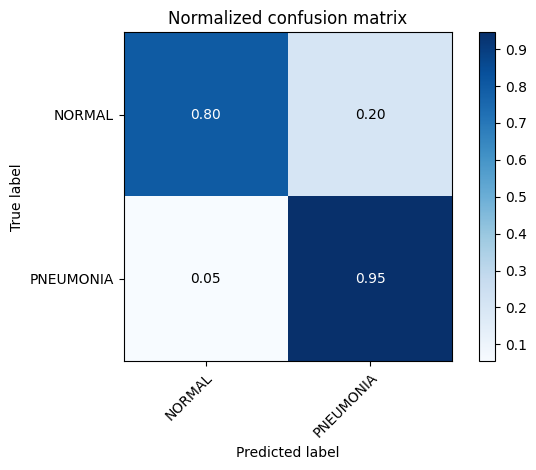

ROC Curve:


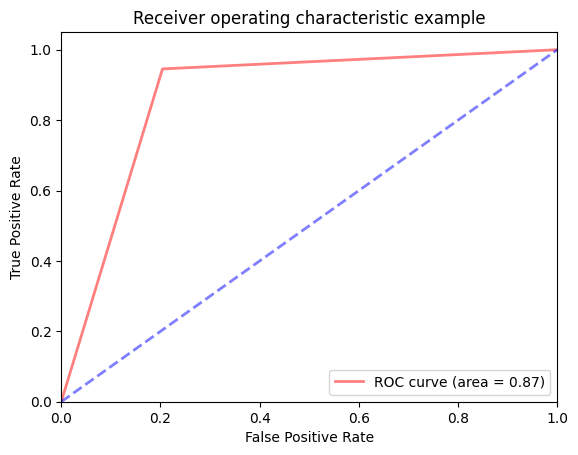


Precision-Recall Curve:


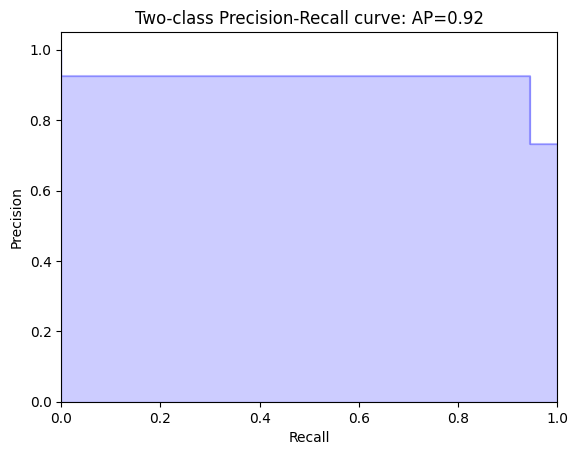

In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

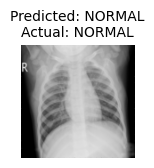

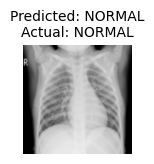

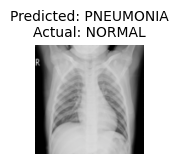

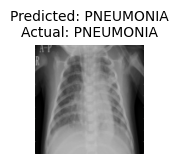

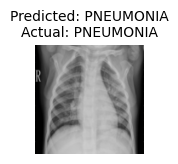

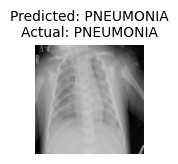

In [31]:
visualize_model(model_conv)

plt.ioff()
plt.show()